The dataset can be accessed from here: [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

In [1]:
import tensorflow as tf
%load_ext tensorboard
import pandas as pd
from keras import backend
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau, LearningRateScheduler
import matplotlib.pyplot as plt
import numpy as np
import datetime
from keras.initializers import glorot_normal, Zeros, he_uniform
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from scipy.io import loadmat

In [2]:
# Load the dataset from your Drive folder
train = loadmat('N:\\ML\\ML Practice\\svnh\\train_32x32.mat')
test = loadmat('N:\\ML\\ML Practice\\svnh\\test_32x32.mat')

## 1. Inspect and preprocess the dataset

In [3]:
train.get('y')[train.get('y') == 10] = 0
test.get('y')[test.get('y') == 10] = 0
num_classes = len(np.unique(train.get('y')))
x_train_grey = np.mean(train.get('X').transpose((3 ,0 ,1, 2)),keepdims=True,axis = -1)
x_test_grey = np.mean(test.get('X').transpose((3 ,0 ,1, 2)),keepdims=True,axis = -1)
(rows, columns) = x_train_grey.shape[1:3]
x_train_mlp = x_train_grey.reshape(x_train_grey.shape[0], rows*(columns))/255.
x_test_mlp = x_test_grey.reshape(x_test_grey.shape[0], rows*(columns))/255.
y_train = to_categorical(train.get('y'))
y_test = to_categorical(test.get('y'))

In [4]:
ctrain = train.get('y').tolist()
ctest = test.get('y').tolist()

In [5]:
classes, dist = np.unique(ctrain+ctest, return_counts = True)
classes_str=[]
classes_str = [str(e) for e in classes.tolist()]

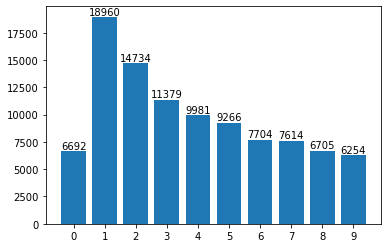

In [6]:
plt.bar(classes,dist,align='center', tick_label=classes_str)
for index, value in zip(classes.tolist(), dist.tolist()):
    plt.text(index, value, str(value), horizontalalignment='center', verticalalignment='bottom')
plt.show()

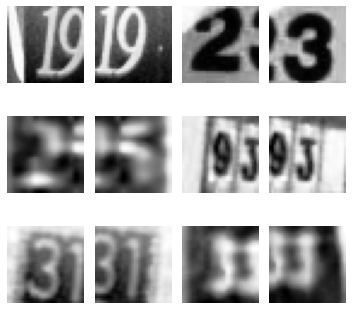

In [7]:
plt.figure(figsize=(5 ,5))
for k in range(12):
    plt.subplot(3, 4, k+1)
    plt.imshow(x_train_grey[k], cmap= 'Greys')
    plt.axis('off')
plt.tight_layout()
plt.show()

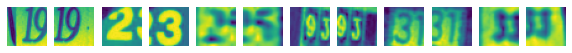

In [8]:
#another way to accomplish what's done above
fig, ax = plt.subplots(1, 12, figsize=(10,10))
for i in range(12):
    ax[i].set_axis_off()
    ax[i].imshow(x_train_grey[i])

C:\Users\ANL\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


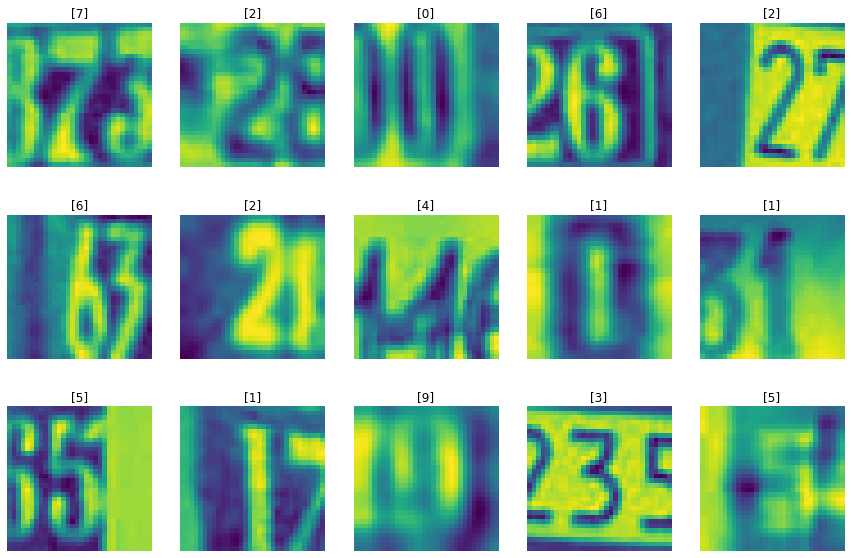

In [9]:
#pick random images with classes

plt.figure(figsize=(15,10))
inx = np.random.choice(x_train_grey.shape[0], 15, replace=False)
for n, i in enumerate(inx):
    ax = plt.subplot(3,5,n+1)
    plt.imshow(x_train_grey[i])
    plt.title(classes[ctrain[i]])
    plt.axis('off')

## 2. MLP neural network classifier

In [6]:
class LearningRateMonitor(Callback):
    #start of training
    def on_train_begin(self, logs={}):
        self.lrates =list()
    #end of each trainin gepoch
    def on_epoch_end(self, epoch, logs={}):
        #getandstorethelearningrate
        optimizer = self.model.optimizer
        lrate =float(backend.get_value(optimizer.lr))
        self.lrates.append(lrate)

In [11]:
#check data imbalance
for i, y in enumerate(dist):
    print('Class = %s, n = %.2f%%' % (i, y/dist.sum()*100))
#use accuracy metric

Class = 0, n = 6.74%
Class = 1, n = 19.10%
Class = 2, n = 14.84%
Class = 3, n = 11.46%
Class = 4, n = 10.05%
Class = 5, n = 9.33%
Class = 6, n = 7.76%
Class = 7, n = 7.67%
Class = 8, n = 6.75%
Class = 9, n = 6.30%


In [7]:
checkpoint = ModelCheckpoint('best_weights', save_weights_only = False, save_best_only = True, monitor = 'val_accuracy', mode ='max')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131200    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0

<AxesSubplot:>

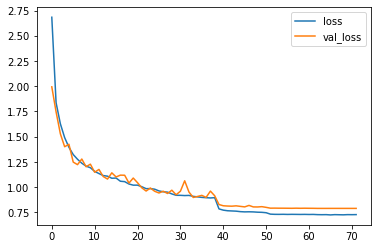

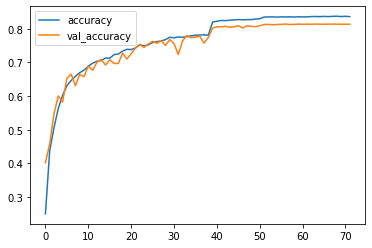

In [7]:
seed = 7
np.random.seed(seed)

w_init = he_uniform
b_init = Zeros()

model = Sequential()
model.add(Input(rows*columns, ))
model.add(Dense(128, kernel_initializer = w_init, bias_initializer = b_init, kernel_regularizer = regularizers.l2(0.001), activation = 'relu'))
model.add(Dense(128, kernel_initializer = w_init, bias_initializer = b_init, kernel_regularizer = regularizers.l2(0.001), activation = 'relu'))
model.add(Dense(128, kernel_initializer = w_init, bias_initializer = b_init, kernel_regularizer = regularizers.l2(0.001), activation = 'relu'))
model.add(Dense(128, kernel_initializer = w_init, bias_initializer = b_init, kernel_regularizer = regularizers.l2(0.001), activation = 'relu'))
model.add(Dense(128, kernel_initializer = w_init, bias_initializer = b_init, kernel_regularizer = regularizers.l2(0.001), activation = 'relu'))
model.add(Dense(128, kernel_initializer = w_init, bias_initializer = b_init, kernel_regularizer = regularizers.l2(0.001), activation = 'relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation = 'softmax'))

#lr =  tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate = 0.001, decay_steps = 1000, alpha = 0.0)

rlrp = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, min_delta=1E-4)
lrm = LearningRateMonitor()
opt = Adam(0.001)
epochs = 100

model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
log_dir = "logs/mlp/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 20, min_delta = 0.005, mode = 'max')
checkpoint = ModelCheckpoint('best_weights', save_weights_only = False, save_best_only = True, monitor = 'val_accuracy', mode ='max')
model.summary()

history = model.fit (x_train_mlp, y_train, epochs = epochs, batch_size = 128, validation_split = 0.2, shuffle = True, verbose = 0, 
                     callbacks = [tensorboard, checkpoint, lrm, rlrp, early_stopping])

df = pd.DataFrame(history.history)
df.plot(y= ["loss","val_loss"],use_index = True)
df.plot(y= [ "accuracy","val_accuracy"] , use_index = True)

In [ ]:
%tensorboard --logdir logs/mlp

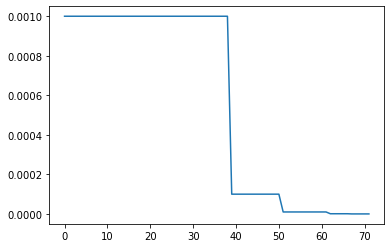

In [8]:
plt.plot(lrm.lrates)

In [9]:
_, train_acc = model.evaluate(x_train_mlp, y_train, verbose=0)
_, test_acc = model.evaluate(x_test_mlp, y_test, verbose=0)

print('Train: %.10f, Test: %.10f' % (train_acc, test_acc))

Train: 0.8349509239, Test: 0.7907575369


In [ ]:
# use this cell to predict new input data
#predictions = model.predict(new_inputs, batch_size = 96)

# KERAS TUNER

In [20]:
import keras_tuner as kt

def model_builder(hp):
    # Tune the number of units in the each dense layer
    hp_units = hp.Int(name = 'units', min_value=128, max_value=256, step=32)
    
    model = Sequential()
    model.add(Input(rows*columns, ))
    model.add(Dense(units = hp_units, kernel_initializer = w_init, bias_initializer = b_init, kernel_regularizer = regularizers.l2(0.001), activation = 'relu'))
    model.add(Dense(units = hp_units, kernel_initializer = w_init, bias_initializer = b_init, kernel_regularizer = regularizers.l2(0.001), activation = 'relu'))
    model.add(Dense(units = hp_units, kernel_initializer = w_init, bias_initializer = b_init, kernel_regularizer = regularizers.l2(0.001), activation = 'relu'))
    model.add(Dense(units = hp_units, kernel_initializer = w_init, bias_initializer = b_init, kernel_regularizer = regularizers.l2(0.001), activation = 'relu'))
    model.add(Dense(units = hp_units, kernel_initializer = w_init, bias_initializer = b_init, kernel_regularizer = regularizers.l2(0.001), activation = 'relu'))
    model.add(Dense(units = hp_units, kernel_initializer = w_init, bias_initializer = b_init, kernel_regularizer = regularizers.l2(0.001), activation = 'relu'))

    # Tune the number of dense layers
    for i in range(hp.Int('num_layers', 1, 2)):
        model.add(Dense(units = hp_units, kernel_initializer = w_init, bias_initializer = b_init, kernel_regularizer = regularizers.l2(0.001), activation = 'relu'))

    # Add dense output layer
    hp_droprate = hp.Choice(name = 'dropout_rate', values = [0.3, 0.4, 0.5])
    model.add(Dropout(hp_droprate))
    model.add(Dense(num_classes, activation = 'softmax'))

    # Tune the learning rate
    hp_learning_rate = hp.Choice(name = 'learning_rate', values = [1e-3, 1e-4, 1e-5])
    
    model.compile(optimizer = Adam(learning_rate = hp_learning_rate),
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

    return model

tuner = kt.Hyperband(model_builder, objective = 'val_accuracy', max_epochs = 10, factor = 3, directory = 'kt_tuner_results', overwrite = True)
tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 32, 'sampling': None}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': None}
dropout_rate (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3, 0.4, 0.5], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001, 1e-05], 'ordered': True}


INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit


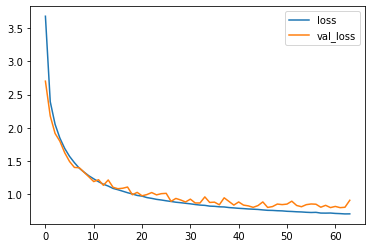

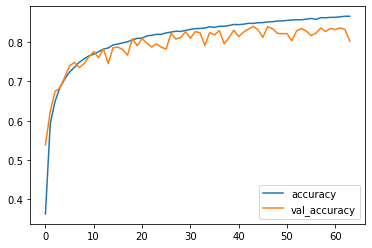

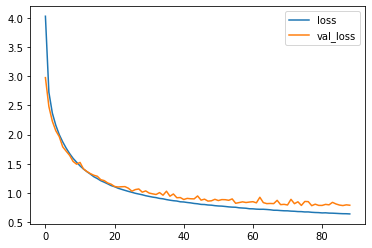

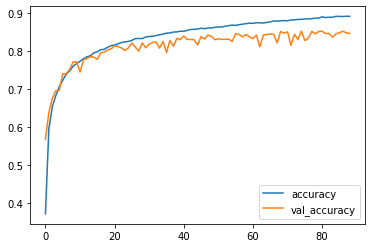

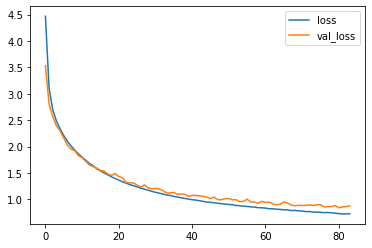

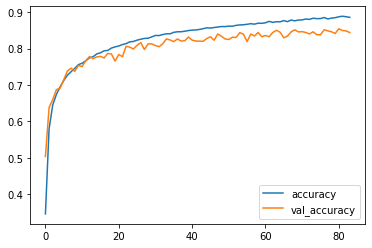

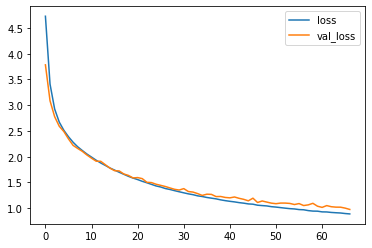

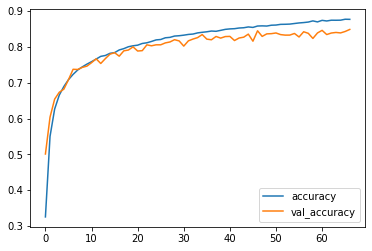

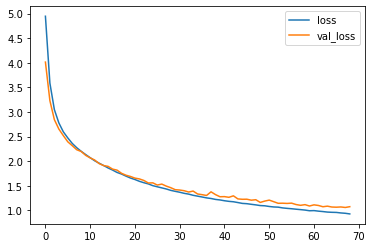

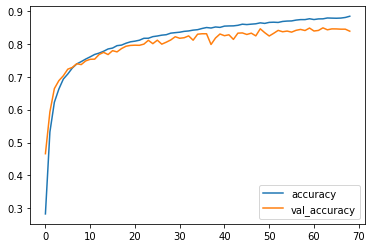

In [22]:
best_results = {'units': [], 'learning rate': [], 'num of layers': [], 'batch size': [], 'dropout rate': [],'mean val acc': [], 'max val acc': []}
for batch_size in [16, 32,64,96,128]:
    tuner.search(x_train_mlp, y_train, epochs = 100, validation_split = 0.2, shuffle = True, verbose = 0)
    best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
    best_model = tuner.hypermodel.build(best_hps)
    history = best_model.fit(x_train_mlp, y_train, epochs = 100, batch_size = batch_size, validation_split = 0.2, shuffle = True, verbose = 0, callbacks = [early_stopping])
    
    #check the plots to see if overfitting occurs in any of the models
    df = pd.DataFrame(history.history)
    df.plot(y= ["loss","val_loss"],use_index = True)
    df.plot(y= [ "accuracy","val_accuracy"] , use_index = True)
    
    best_results['units'].append(best_hps.get('units'))
    best_results['learning rate'].append(best_hps.get('learning_rate'))
    best_results['num of layers'].append(best_hps.get('num_layers'))
    best_results['batch size'].append(batch_size)
    best_results['batch size'].append(best_hps.get('dropout_rate'))
    best_results['mean val acc'].append(np.mean(history.history['val_accuracy']))
    best_results['max val acc'].append(np.max(history.history['val_accuracy']))

In [23]:
best_results

{'units': [256, 256, 256, 256, 256],
 'learning rate': [0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
 'num of layers': [1, 1, 1, 1, 1],
 'batch size': [16, 0.4, 32, 0.4, 64, 0.4, 96, 0.4, 128, 0.4],
 'dropout rate': [],
 'mean val acc': [0.793191627599299,
  0.8125070929527283,
  0.8059179335832596,
  0.7963591129032533,
  0.7981301459713258],
 'max val acc': [0.8402265906333923,
  0.852716326713562,
  0.8546956181526184,
  0.8484848737716675,
  0.8488261103630066]}

In [30]:
tuner.results_summary(1)

Results summary
Results in kt_tuner_results\untitled_project
Showing 1 best trials
Trial summary
Hyperparameters:
units: 256
num_layers: 1
dropout_rate: 0.4
learning_rate: 0.0001
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.7596232891082764


In [33]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.get('units'))
print(best_hps.get('learning_rate'))
print(best_hps.get('num_layers'))

256
0.0001
1


In [34]:
#select the 4th configuration

best_model = Sequential()
best_model.add(Input(rows*columns, ))
best_model.add(Dense(units = best_results['units'][3], kernel_initializer = w_init, bias_initializer = b_init, kernel_regularizer = regularizers.l2(0.001), activation = 'relu'))
best_model.add(Dense(units = best_results['units'][3], kernel_initializer = w_init, bias_initializer = b_init, kernel_regularizer = regularizers.l2(0.001), activation = 'relu'))
best_model.add(Dense(units = best_results['units'][3], kernel_initializer = w_init, bias_initializer = b_init, kernel_regularizer = regularizers.l2(0.001), activation = 'relu'))
best_model.add(Dense(units = best_results['units'][3], kernel_initializer = w_init, bias_initializer = b_init, kernel_regularizer = regularizers.l2(0.001), activation = 'relu'))
best_model.add(Dense(units = best_results['units'][3], kernel_initializer = w_init, bias_initializer = b_init, kernel_regularizer = regularizers.l2(0.001), activation = 'relu'))
best_model.add(Dense(units = best_results['units'][3], kernel_initializer = w_init, bias_initializer = b_init, kernel_regularizer = regularizers.l2(0.001), activation = 'relu'))
best_model.add(Dense(units = best_results['units'][3], kernel_initializer = w_init, bias_initializer = b_init, kernel_regularizer = regularizers.l2(0.001), activation = 'relu'))
best_model.add(Dropout(0.4))
best_model.add(Dense(num_classes, activation = 'softmax'))
best_model.compile(optimizer = Adam(learning_rate = best_results['learning rate'][3]),
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])



In [35]:
history = best_model.fit(x_train_mlp, y_train, epochs = 100, batch_size = 96, validation_split = 0.2, shuffle = True, verbose = 0, callbacks = [early_stopping])

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 94


In [36]:
#train on the full dataset
best_model.fit(x_train_mlp, y_train, epochs = best_epoch * 2, batch_size = 96, shuffle = True, verbose = 0)

In [38]:
best_model.evaluate(x_test_mlp, y_test)
_, test_acc = best_model.evaluate(x_test_mlp, y_test, verbose=0)

print('Test accuracy: %.10f' % (test_acc))

814/814 [==============================] - 2s 3ms/step - loss: 0.9187 - accuracy: 0.8367
Test accuracy: 0.8366625905


In [39]:
#save the best_model
best_model.save('entire_best_model')
best_model.save_weights('best_model_weights')

INFO:tensorflow:Assets written to: entire_best_model\assets


In [ ]:
#load the entire_best_model and its weights for predictions later on
new_model = tf.keras.models.load_model('entire_best_model')
new_model_weights = tensorflow.keras.models.load_weights('best_model_weights')
#predictions = best_model.predict(x_input, batch_size = 128)

# ------------------------------------------------------------------------------------------

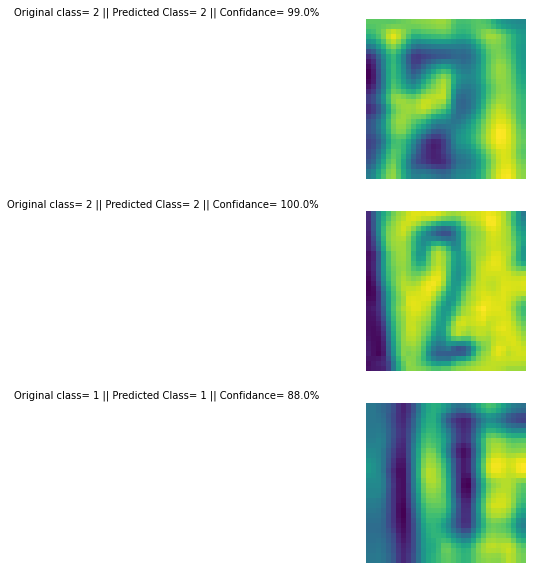

In [172]:
#below code checks if predicted class is correct in addition to displaying confidence and the image in the dataset
plt.figure(figsize=(15,10))
num_of_images_to_display = 3
inx = np.random.choice(100, num_of_images_to_display, replace=False)
for n, i in enumerate(inx):
    ax = plt.subplot(num_of_images_to_display,1,n+1)
    plt.imshow(x_test_grey[i])
    plt.text(-10, -1, 'Original class= ' + str(np.argmax(y_test[i])) + ' || Predicted Class= ' + str(np.argmax(predictions[i])) + 
             ' || Confidence= ' + str(np.round(np.max(predictions[i])*100)) + '%' , horizontalalignment= 'right', verticalalignment ='bottom')
    plt.axis('off')

In [164]:
np.max(predictions[526])

0.39856198

## 3. CNN neural network classifier

In [7]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 20, min_delta = 0.005, mode = 'max')
rlrp = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, min_delta=1E-4)
w_init = he_uniform
b_init = Zeros()
#model.add(Dense(128, kernel_initializer = w_init, bias_initializer = b_init, kernel_regularizer = regularizers.l2(0.001), activation = 'relu'))

In [19]:
x_train_cnn = x_train_grey.reshape(x_train_grey.shape[0], rows, columns, x_train_grey.shape[-1])/255.
x_test_cnn = x_test_grey.reshape(x_test_grey.shape[0], rows, columns, x_test_grey.shape[-1])/255.

batch_size = 32
tgen = ImageDataGenerator(rotation_range = 15, width_shift_range = 0.1, height_shift_range = 0.1, zoom_range = 0.15)
train_gen = tgen.flow(x_train_cnn, y_train, batch_size, shuffle = True)
vgen = ImageDataGenerator()
val_gen = vgen.flow(x_test_cnn, y_test, batch_size, shuffle = True) #instead of using the test dataset here, you can create a validation data set and use it instead since we'd want to use test dataset
                                                    # in .evaluate

model = Sequential()
model.add(Input(shape = (rows, columns, 1)))

model.add(Conv2D(32, (3,3), activation = 'relu', kernel_initializer = w_init, bias_initializer = b_init, kernel_regularizer = regularizers.l2(0.001)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(32, (3,3), activation = 'relu', kernel_initializer = w_init, bias_initializer = b_init, kernel_regularizer = regularizers.l2(0.001)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64, activation = 'relu', kernel_initializer = w_init, bias_initializer = b_init, kernel_regularizer = regularizers.l2(0.001)))
model.add(Dense(64, activation = 'relu', kernel_initializer = w_init, bias_initializer = b_init, kernel_regularizer = regularizers.l2(0.001)))
model.add(Dense(num_classes, activation = 'softmax'))

model.compile(optimizer = Adam(0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 15, 15, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 6, 32)         0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 6, 6, 32)         

In [20]:
history_1 = model.fit(train_gen, steps_per_epoch = len(x_train_cnn) // batch_size, validation_data = val_gen, validation_steps=len(x_test_cnn) // batch_size, epochs = 100, verbose = 0, callbacks = [early_stopping, rlrp])

<AxesSubplot:>

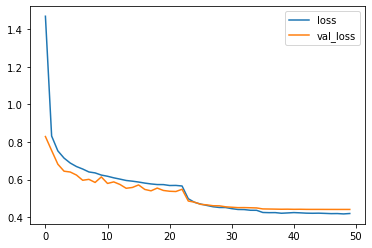

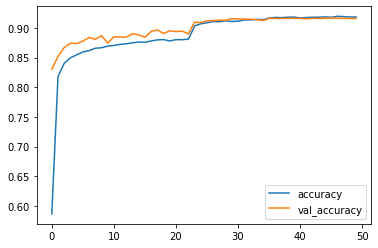

In [16]:
# results without augmentation
df = pd.DataFrame(history.history)
df.plot(y= ["loss","val_loss"],use_index = True)
df.plot(y= [ "accuracy","val_accuracy"] , use_index = True)

In [17]:
_, train_acc = model.evaluate(x_train_cnn, y_train, verbose=0)
_, test_acc = model.evaluate(x_test_cnn, y_test, verbose=0)

print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.937, Test: 0.909


In [18]:
print("Best validation accuracy: {:0.3f}".format(np.max(history.history['val_accuracy'])))
print("Best training accuracy: {:0.3f}".format(np.max(history.history['accuracy'])))

Best validation accuracy: 0.916
Best training accuracy: 0.919


<AxesSubplot:>

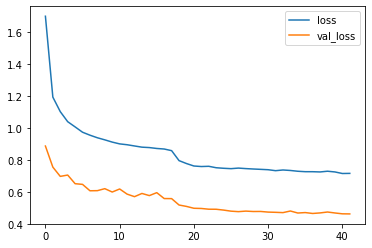

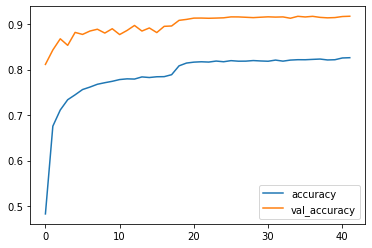

In [21]:
# results with augmentation
df_1 = pd.DataFrame(history_1.history)
df_1.plot(y= ["loss","val_loss"],use_index = True)
df_1.plot(y= [ "accuracy","val_accuracy"] , use_index = True)

In [22]:
_, train_acc = model.evaluate(x_train_cnn, y_train, verbose=0)
_, test_acc = model.evaluate(x_test_cnn, y_test, verbose=0)

print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.911, Test: 0.917


In [23]:
print("Best validation accuracy: {:0.3f}".format(np.max(history_1.history['val_accuracy'])))
print("Best training accuracy: {:0.3f}".format(np.max(history_1.history['accuracy'])))

Best validation accuracy: 0.917
Best training accuracy: 0.826


## KERAS TUNER

In [ ]:
# similarly, can run kerastuner for CNN as well but I'll skip it
search_space = {'rotation_range': hp.Choice(name = 'rotation_range', values = [15, 30])
                'kernel_size': hp.Choice(name = 'kernel_size', values = [3, 5, 7])
                'dense_units': hp.Int(name = 'dense_units', min = 32, max = 256, step = 128)
                'dropout_rate': hp.Choice(name = 'dropout_rate', values = [0.2, 0.3, 0.4, 0.5])}

## Transfer Learning

In [8]:
w_init = he_uniform
b_init = Zeros()
rlrp = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, min_delta=1E-4)
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 20, min_delta = 0.005, mode = 'max')
opt = Adam(0.001)

In [9]:
conv_base = tf.keras.applications.vgg16.VGG16(weights = 'imagenet', include_top = False, input_shape = (32, 32, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [92]:
conv_base.trainable = False

In [93]:
data_augmentation = Sequential([tf.keras.layers.RandomRotation(0.04),
                               tf.keras.layers.RandomWidth(0.1),
                               tf.keras.layers.RandomHeight(0.1),
                               tf.keras.layers.RandomZoom(0.15)])

In [94]:
inputs = Input(shape = (32, 32, 3))
x = data_augmentation(inputs)
x = conv_base(inputs)
x = Flatten()(x)
x = Dense(units = 64, kernel_initializer = w_init, bias_initializer = b_init, kernel_regularizer = regularizers.l2(0.001), activation = 'relu')(x)
x = Dense(units = 64, kernel_initializer = w_init, bias_initializer = b_init, kernel_regularizer = regularizers.l2(0.001), activation = 'relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation = 'softmax')(x)
tl_model = tf.keras.Model(inputs, outputs)
tl_model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
tl_model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_14 (Flatten)        (None, 512)               0         
                                                                 
 dense_42 (Dense)            (None, 64)                32832     
                                                                 
 dense_43 (Dense)            (None, 64)                4160      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_44 (Dense)            (None, 10)                650

In [95]:
prepro_input_x = train.get('X').reshape(train.get('X').shape[3], train.get('X').shape[0], train.get('X').shape[1], train.get('X').shape[2])

In [96]:
preprocessed_input = tf.keras.applications.vgg16.preprocess_input(prepro_input_x)

In [ ]:
# use small epoch number as it takes too much time on my computer
tl_history = tl_model.fit (preprocessed_input, train.get('y'), epochs = 10, batch_size = 128, validation_split = 0.2, shuffle = True, verbose = 0, callbacks = [rlrp, early_stopping])

<AxesSubplot:>

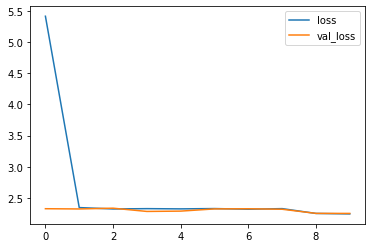

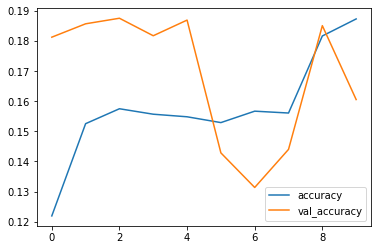

In [16]:
df = pd.DataFrame(tl_history.history)
df.plot(y= ["loss","val_loss"],use_index = True)
df.plot(y= [ "accuracy","val_accuracy"] , use_index = True)

### Fine-tune transfer learning

In [112]:
# unfreeze top 4 layers
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False
tl_model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
tl_history_tuned = tl_model.fit (preprocessed_input, train.get('y'), epochs = 10, batch_size = 128, validation_split = 0.2 shuffle = True, verbose = 0, callbacks = [rlrp, early_stopping])

In [ ]:
df = pd.DataFrame(tl_history_tuned.history)
df.plot(y= ["loss","val_loss"],use_index = True)
df.plot(y= [ "accuracy","val_accuracy"] , use_index = True)

In [ ]:
test_loss, test_acc = tl_model.evaluate(test.get('X'))